/tmp/ipykernel_18420/2500448465.py:11: RuntimeWarning: covariance is not positive-semidefinite.
  X1 = np.random.multivariate_normal(mu_1, sigma_1,points)
/tmp/ipykernel_18420/2500448465.py:12: RuntimeWarning: covariance is not positive-semidefinite.
  X2 = np.random.multivariate_normal(mu_2, sigma_2,points)
/tmp/ipykernel_18420/2500448465.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X1[:,0],X1[:,1],cmap='red')
/tmp/ipykernel_18420/2500448465.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X2[:,0],X2[:,1],cmap='green')


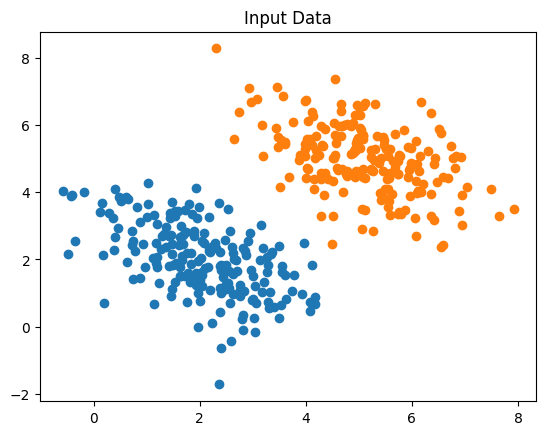

In [33]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

points = 200
mu_1 = np.array([2,2])
mu_2 = np.array([5,5])
sigma_1 = np.array([[-1, 0.5], [0.5, -1]])
sigma_2 = np.array([[-1, 0.5], [0.5, -1]])
X1 = np.random.multivariate_normal(mu_1, sigma_1,points)
X2 = np.random.multivariate_normal(mu_2, sigma_2,points)
X = np.concatenate((X1,X2),axis=0)

y1 = np.zeros((points,1))
y2 = np.ones((points,1))
y = np.concatenate((y1, y2), 0)

plt.scatter(X1[:,0],X1[:,1],cmap='red')
plt.scatter(X2[:,0],X2[:,1],cmap='green')
plt.title("Input Data")
plt.show()

In [34]:
# Place code to split the data, fit the LR model, output accuracy, and plot the result here
def partition(X, y, percent_train=0.8):
    m = y.shape[0]
    idx = np.arange(0,m)
    random.seed(1412)
    random.shuffle(idx)
    #percent_train = 0.6
    m_train = int(m * percent_train)
    train_idx = idx[:m_train]
    test_idx = idx[m_train:]
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]
    return X_train, X_test,y_train, y_test

X_train, X_val, y_train, y_val = partition(X, y, 0.8)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


(320, 2) (80, 2) (320, 1) (80, 1)


In [35]:
m,n = X_train.shape
m,n

(320, 2)

In [36]:
import numpy as np
import cvxopt

def cvxopt_solve_qp(Q, c, A=None, b=None, E=None, d=None):
    Q = .5 * (Q + Q.T)  # make sure Q is symmetric
    args = [cvxopt.matrix(Q), cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
        if E is not None:
            args.extend([cvxopt.matrix(E), cvxopt.matrix(d)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((Q.shape[1],))

def linear_kernel(X):
    m = X.shape[0]
    K = np.matrix(np.zeros([m,m]))
    for i in range(0,m):
        for j in range(0,m):
            K[i,j] = X[i,:]@(X[j,:].T)
    return K

def predict(x, X, y, alpha):
    s = []
    sigma = 0.2
    for j in range(x.shape[0]):
        ss = 0
        for i in range(X.shape[0]):
            ss += alpha[i]*y[i]*np.exp((-(X[i]-x[j])@(X[i]-x[j]))/(2*sigma*sigma))
        s.append(ss)
    s = np.array(s)
    s[s >= 0] = 1
    s[s < 0] = -1
    return s



In [37]:
#Convert 0/1 targets to -1/+1
y_train_svm = y_train
y_train_svm[y_train == 0] = -1
y_test_svm = y_val
y_test_svm[y_val == 0] = -1

In [38]:
K = linear_kernel(X_train)
Q = np.multiply(y_train_svm * y_train_svm.T, K)
print('Q rank: %d' % np.linalg.matrix_rank(Q))
c = -np.ones([m])
A = -np.eye(m)
b = np.zeros([m])
E = y_train_svm.T
d = np.zeros(1)
alpha_star = cvxopt_solve_qp(Q, c, A, b, E, d)
print("Optimal alpha:")
print(alpha_star)

Q rank: 2
     pcost       dcost       gap    pres   dres
 0: -3.3735e+01 -6.7841e+01  1e+03  3e+01  2e+00
 1: -4.3432e+01 -4.3507e+01  6e+02  2e+01  1e+00
 2: -8.9102e+01 -7.6607e+01  6e+02  1e+01  8e-01
 3: -4.8721e+02 -3.6698e+02  6e+02  1e+01  7e-01
 4: -5.6262e+02 -3.7795e+02  7e+02  1e+01  7e-01
 5: -3.1630e+02 -1.1123e+02  5e+02  5e+00  3e-01
 6: -5.9437e+00 -1.2885e+01  3e+01  1e-01  8e-03
 7: -8.6383e+00 -9.9424e+00  3e+00  1e-02  8e-04
 8: -9.8222e+00 -9.8467e+00  6e-02  2e-04  1e-05
 9: -9.8451e+00 -9.8454e+00  6e-04  2e-06  1e-07
10: -9.8454e+00 -9.8454e+00  6e-06  2e-08  1e-09
Optimal solution found.
Optimal alpha:
[ 1.31007009e-09  1.11486171e-09  1.35412726e-09 -7.64326662e-10
 -9.03831592e-11  9.58781592e-10  1.08149607e-09  5.57076988e-10
  1.03704957e-10  2.97983230e-10  2.88997609e-10  1.47250796e-09
  2.83381579e-10  1.80094081e-09  1.19859667e-10 -2.12958582e-11
  8.33039137e-10  9.09710706e-10  5.43550494e-10  1.27125016e-09
 -6.37406721e-11  6.60908714e-10  1.136

In [39]:
y_pred = predict(X_val, X_val, y_val, alpha_star)
print("Accuracy :",np.sum(y_val == y_pred)/y_val.size)

Accuracy : 0.9625


In [40]:
def get_wb(X, y, alpha):
    # Find the support vectors
    S = alpha > 1e-6
    XS = X[S,:]
    yS = y[S]
    alphaS = alpha[S]
    alphaSyS = np.tile(np.multiply(yS.T, alphaS).T, n)
    w = sum(np.multiply(alphaSyS, XS)).T
    # Find b
    KS = K[S,:][:,S]
    NS = yS.shape[0]
    b = (np.sum(yS) - np.sum(np.multiply(alphaS,yS.T)*KS))/NS
    # Normalize w,b
    scalef = np.linalg.norm(w)
    w = w / scalef
    b = b / scalef
    return w,b

w,b = get_wb(X_train, y_train_svm, alpha_star)

print("Optimal w: [%f,%f] b: %f" % (w[0],w[1],b))
print(w.shape,b.shape)

Optimal w: [0.858471,0.512861] b: -4.906733
(2,) ()


In [41]:
w,b = get_wb(X_train, y_train_svm, alpha_star)

In [42]:
def plot_data(X, y):
    X_0 = X[(y==-1).flat]
    X_1 = X[(y==1).flat]
    axes = plt.axes()
    plt.plot(X_0[:,0], X_0[:,1], 'ro',label='class 1')
    plt.plot(X_1[:,0], X_1[:,1], 'bo',label='class 2')
    axes.set_aspect('equal', 'datalim')
    plt.legend()
    return axes
    
def plot_w(w,b):
    ylim = plt.axes().get_ylim()
    xlim = plt.axes().get_xlim()
    print(xlim,ylim)
    p1 = (xlim[0], - (w[0] * xlim[0] + b) / w[1])
    p2 = (xlim[1], - (w[0] * xlim[1] + b) / w[1])
    plt.plot((p1[0],p2[0]), (p1[1],p2[1]), 'g-')

In [43]:
def plot_data_test (w,b,X, y):
    ylim = plt.axes().get_ylim()
    xlim = plt.axes().get_xlim()
    print(xlim,ylim)
    p1 = (xlim[0], - (w[0] * xlim[0] + b) / w[1])
    p2 = (xlim[1], - (w[0] * xlim[1] + b) / w[1])
    plt.plot((p1[0],p2[0]), (p1[1],p2[1]), 'g-')
    X_0 = X[(y==-1).flat]
    X_1 = X[(y==1).flat]
    axes = plt.axes()
    plt.plot(X_0[:,0], X_0[:,1], 'ro',label='class 1')
    plt.plot(X_1[:,0], X_1[:,1], 'bo',label='class 2')
    axes.set_aspect('equal', 'datalim')
    plt.legend()
    #return axes

(0.0, 1.0) (0.0, 1.0)


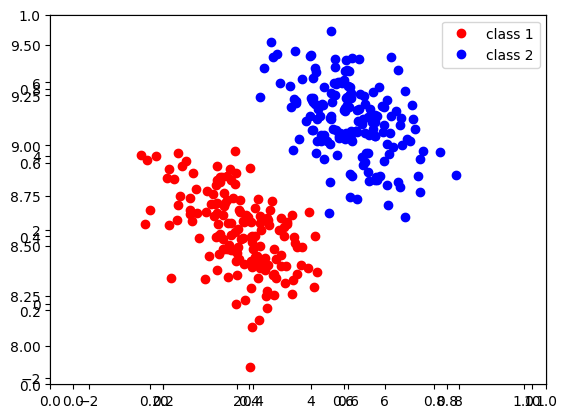

In [44]:
plot_data_test(w, b, X_train,y_train)

In [45]:
def plot_margin(X1_train, X2_train, w, b, sv):
    def f(x, w, b, c=0):
    # given x, return y such that [x,y] in on the line
    # w.x + b = c
        return (-w[0] * x - b + c) / w[1]
    
    plt.plot(X1_train[:,0], X1_train[:,1], "ro")
    plt.plot(X2_train[:,0], X2_train[:,1], "bo")
    plt.scatter(sv[:,0], sv[:,1], s=100, c="g")
    # w.x + b = 0
    a0 = -2; a1 = f(a0, w, b)
    b0 = 2; b1 = f(b0, w, b)
    plt.plot([a0,b0], [a1,b1], "k")
    #pl.plot([a0,b0], [10,10], "k")
    # w.x + b = 1
    a0 = -2; a1 = f(a0, w, b, 1)
    b0 = 2; b1 = f(b0, w, b, 1)
    plt.plot([a0,b0], [a1,b1], "k")
    # w.x + b = -1
    a0 = -2; a1 = f(a0, w, b, -1)
    b0 = 2; b1 = f(b0, w, b, -1)
    plt.plot([a0,b0], [a1,b1], "k")
    plt.axis("tight")
    plt.show()